In [29]:
#PreProcessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
import joblib
import warnings
warnings.filterwarnings('ignore')
#Feature Engineering
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier        # recommended for feature importance
from catboost import CatBoostClassifier  # optional alternative, handles categorical features natively
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap

In [30]:
df = pd.read_csv('C:/Users/Sultan/Downloads/ML/ML_Project/3. Stroke Prediction/csv files/0_stroke.csv')

In [31]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Preprocessing

In [32]:
df = df.drop(['id'],axis=1)

In [33]:
#find missing values
miss_val = df.isna().sum()
print(miss_val)

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [34]:
#handling missing values
# Fill missing values in 'bmi' column with median
df["bmi"].fillna(df["bmi"].median(), inplace=True)
# Check if any missing values remain
print(df["bmi"].isnull().sum())

0


In [35]:
#finding outliers
min_max_values = df.aggregate(['min','max'])
print(min_max_values)

     gender    age  hypertension  heart_disease ever_married work_type  \
min  Female   0.08             0              0           No  Govt_job   
max   Other  82.00             1              1          Yes  children   

    Residence_type  avg_glucose_level   bmi smoking_status  stroke  
min          Rural              55.12  10.3        Unknown       0  
max          Urban             271.74  97.6         smokes       1  


In [36]:
#handling outliers
# Age: remove values < 1
df = df[df["age"] >= 1]
# BMI: clip to medically reasonable range
df["bmi"] = df["bmi"].clip(lower=15, upper=60)

In [37]:
print(df["gender"].value_counts())

gender
Female    2979
Male      2087
Other        1
Name: count, dtype: int64


In [38]:
df = df[df["gender"] != "Other"]

In [39]:
#again checking for outliers
min_max_values = df.aggregate(['min','max'])
print(min_max_values)

     gender   age  hypertension  heart_disease ever_married work_type  \
min  Female   1.0             0              0           No  Govt_job   
max    Male  82.0             1              1          Yes  children   

    Residence_type  avg_glucose_level   bmi smoking_status  stroke  
min          Rural              55.12  15.0        Unknown       0  
max          Urban             271.74  60.0         smokes       1  


In [40]:
print(df["work_type"].value_counts())

work_type
Private          2924
Self-employed     819
Govt_job          657
children          644
Never_worked       22
Name: count, dtype: int64


## Encoding

In [41]:
df['ever_married'] = df['ever_married'].map({'No':0, 'Yes':1})
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
df['Residence_type'] = df['Residence_type'].map({'Rural':0, 'Urban':1})

In [42]:
#One-Hot Encoding for work_type & smoking_status
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
ohe_features = ohe.fit_transform(df[['work_type', 'smoking_status']])

# Create dataframe with encoded columns
ohe_df = pd.DataFrame(ohe_features, columns=ohe.get_feature_names_out(['work_type', 'smoking_status']))

# Drop original cols and concat new
df = df.drop(columns=['work_type', 'smoking_status']).reset_index(drop=True)
df = pd.concat([df, ohe_df], axis=1)

In [43]:
#saving encoder
joblib.dump(ohe, "onehot_encoder_strok.pkl")

['onehot_encoder_strok.pkl']

## Scaling

In [44]:
scaler = StandardScaler()
df[['age', 'avg_glucose_level', 'bmi']] = scaler.fit_transform(df[['age', 'avg_glucose_level', 'bmi']])

In [45]:
joblib.dump(scaler, "scaler_strok.pkl")

['scaler_strok.pkl']

In [46]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,1.046818,0,1,1,1,2.697766,1.020940,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,0.778489,0,0,1,0,2.114397,-0.111398,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0,1.628198,0,1,1,0,-0.006924,0.474753,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1,0.241830,0,0,1,1,1.431891,0.727864,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1,1.583476,1,0,1,0,1.495559,-0.657585,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [47]:
#removing .0
df['work_type_Never_worked'] = df['work_type_Never_worked'].astype(int)
df['work_type_Private'] = df['work_type_Private'].astype(int)
df['work_type_Self-employed'] = df['work_type_Self-employed'].astype(int)
df['work_type_children'] = df['work_type_children'].astype(int)
df['smoking_status_formerly smoked'] = df['smoking_status_formerly smoked'].astype(int)
df['smoking_status_never smoked'] = df['smoking_status_never smoked'].astype(int)
df['smoking_status_smokes'] = df['smoking_status_smokes'].astype(int)

In [48]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,1.046818,0,1,1,1,2.697766,1.020940,1,0,1,0,0,1,0,0
1,1,0.778489,0,0,1,0,2.114397,-0.111398,1,0,0,1,0,0,1,0
2,0,1.628198,0,1,1,0,-0.006924,0.474753,1,0,1,0,0,0,1,0
3,1,0.241830,0,0,1,1,1.431891,0.727864,1,0,1,0,0,0,0,1
4,1,1.583476,1,0,1,0,1.495559,-0.657585,1,0,0,1,0,0,1,0


In [50]:
df.to_csv('C:/Users/Sultan/Downloads/ML/ML_Project/3. Stroke Prediction/csv files/1_prep_stroke.csv',index=False)

## Imbalance Learning

In [51]:
df_syn = pd.read_csv('C:/Users/Sultan/Downloads/ML/ML_Project/3. Stroke Prediction/csv files/1_prep_stroke.csv')

In [52]:
y = df_syn['stroke']
print(y.value_counts())

stroke
0    4817
1     249
Name: count, dtype: int64


In [53]:
X = df_syn.drop(['stroke'],axis=1)
# Minority will become 75% of majority
smote = SMOTE(sampling_strategy=0.75, random_state=42)  
X_res, y_res = smote.fit_resample(X, y)
print("Original:", y.value_counts())
print("After SMOTE:", y_res.value_counts())

Original: stroke
0    4817
1     249
Name: count, dtype: int64
After SMOTE: stroke
0    4817
1    3612
Name: count, dtype: int64


In [54]:
df_syn = pd.concat([pd.DataFrame(X_res, columns=X.columns), 
                    pd.DataFrame(y_res, columns=['stroke'])], axis=1)

In [56]:
print(df_syn['stroke'].value_counts())

stroke
0    4817
1    3612
Name: count, dtype: int64


In [57]:
df_syn.to_csv('C:/Users/Sultan/Downloads/ML/ML_Project/3. Stroke Prediction/csv files/2_syn_stroke.csv',index=False)

## Feature Engineering

### for preprocessed

In [58]:
df_prep_sel = pd.read_csv('C:/Users/Sultan/Downloads/ML/ML_Project/3. Stroke Prediction/csv files/1_prep_stroke.csv')

In [59]:
X_p = df_prep_sel.drop(columns=['stroke'],axis=1)
y_p = df_prep_sel['stroke']

In [60]:
fi_model = RandomForestClassifier()
fi_model.fit(X_p,y_p)

RandomForestClassifier()

In [61]:
# Get feature importance
importances = fi_model.feature_importances_
feat_importance = pd.DataFrame({
    'Feature': X_p.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_importance.to_string(index=False))

                       Feature  Importance
             avg_glucose_level    0.280914
                           age    0.251235
                           bmi    0.235872
                Residence_type    0.032468
                        gender    0.030612
                  hypertension    0.026940
                 heart_disease    0.026272
             work_type_Private    0.021908
   smoking_status_never smoked    0.020679
smoking_status_formerly smoked    0.018677
       work_type_Self-employed    0.018160
         smoking_status_smokes    0.018106
                  ever_married    0.017179
            work_type_children    0.000956
        work_type_Never_worked    0.000021


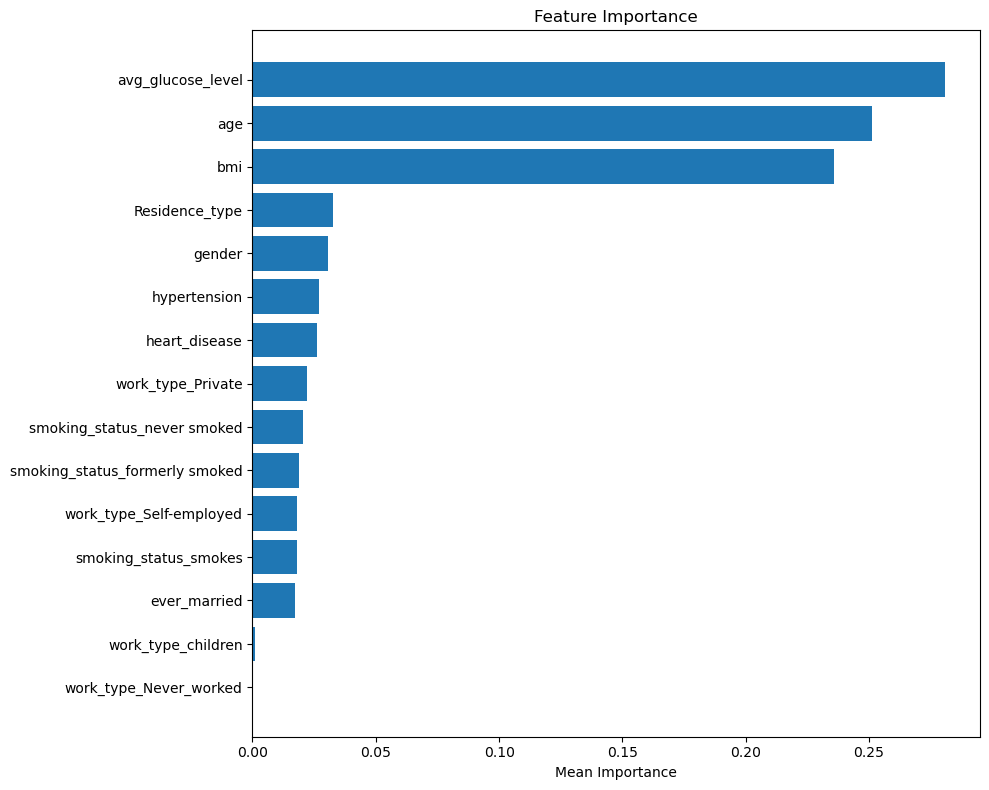

In [62]:
importance_sorted = feat_importance.sort_values(by="Importance", ascending=True)
# Plot
plt.figure(figsize=(10, 8))
plt.barh(importance_sorted['Feature'], importance_sorted['Importance'])
plt.xlabel("Mean Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

In [64]:
#drop unimportant features
X_p = X_p.drop(columns=['work_type_children','work_type_Never_worked'])

KeyError: "['work_type_children', 'work_type_Never_worked'] not found in axis"

In [66]:
df_prep_sel = pd.concat([pd.DataFrame(X_p, columns=X_p.columns),
                         pd.DataFrame(y_p, columns=['stroke'])], axis=1)

In [67]:
df_prep_sel

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_Private,work_type_Self-employed,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,0,1.046818,0,1,1,1,2.697766,1.020940,1,0,1,0,0,1
1,1,0.778489,0,0,1,0,2.114397,-0.111398,0,1,0,1,0,1
2,0,1.628198,0,1,1,0,-0.006924,0.474753,1,0,0,1,0,1
3,1,0.241830,0,0,1,1,1.431891,0.727864,1,0,0,0,1,1
4,1,1.583476,1,0,1,0,1.495559,-0.657585,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5061,1,1.628198,1,0,1,1,-0.495341,-0.111398,1,0,0,1,0,0
5062,1,1.672919,0,0,1,1,0.417825,1.473876,0,1,0,1,0,0
5063,1,-0.384271,0,0,1,0,-0.512084,0.221642,0,1,0,1,0,0
5064,0,0.331273,0,0,1,0,1.323060,-0.444439,1,0,1,0,0,0


In [68]:
df_prep_sel.to_csv('C:/Users/Sultan/Downloads/ML/ML_Project/3. Stroke Prediction/csv files/3_prep_sel_stroke.csv',index=False)

In [75]:
df_syn_sel = pd.read_csv('C:/Users/Sultan/Downloads/ML/ML_Project/3. Stroke Prediction/csv files/2_syn_stroke.csv')

In [76]:
X_s = df_syn_sel.drop(columns=['stroke'],axis=1)
y_s = df_syn_sel['stroke']

In [77]:
fi_model_1 = RandomForestClassifier()
fi_model_1.fit(X_s,y_s)

RandomForestClassifier()

In [78]:
# Get feature importance
importances_s = fi_model_1.feature_importances_
feat_importance_s = pd.DataFrame({
    'Feature': X_s.columns,
    'Importance': importances_s
}).sort_values(by='Importance', ascending=False)

print(feat_importance_s.to_string(index=False))

                       Feature  Importance
                           age    0.400758
             avg_glucose_level    0.199682
                           bmi    0.178954
                  ever_married    0.031339
                Residence_type    0.024687
   smoking_status_never smoked    0.023832
                        gender    0.023564
             work_type_Private    0.022586
       work_type_Self-employed    0.017666
                  hypertension    0.016869
            work_type_children    0.016440
         smoking_status_smokes    0.014775
smoking_status_formerly smoked    0.014453
                 heart_disease    0.014185
        work_type_Never_worked    0.000210


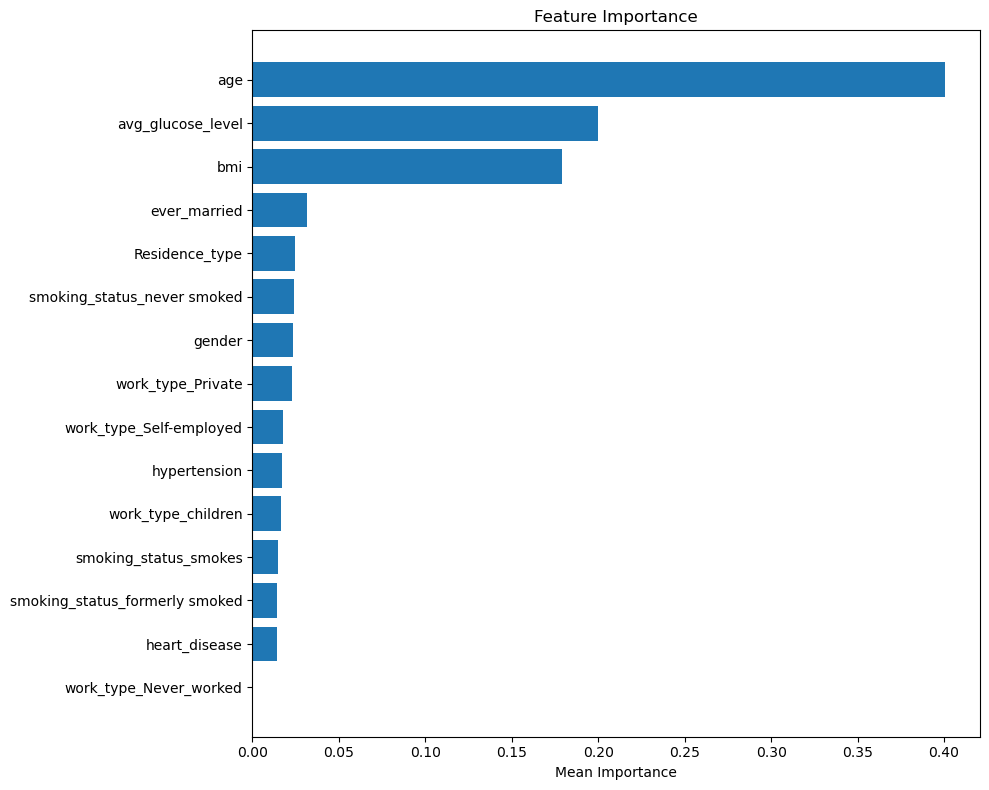

In [79]:
importance_sorted_s = feat_importance_s.sort_values(by="Importance", ascending=True)
# Plot
plt.figure(figsize=(10, 8))
plt.barh(importance_sorted_s['Feature'], importance_sorted_s['Importance'])
plt.xlabel("Mean Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

In [80]:
threshold = 0.031339
# Keep only features above threshold
important_features = feat_importance_s[feat_importance_s['Importance'] >= threshold]['Feature']

# Select only those columns from X_s
X_selected = X_s[important_features]

# Combine back with target
df_syn_sel_new = pd.concat([X_selected, y_s], axis=1)

print("\nSelected features after thresholding:", list(important_features))
print("\nNew dataframe shape:", df_syn_sel_new.shape)


Selected features after thresholding: ['age', 'avg_glucose_level', 'bmi', 'ever_married']

New dataframe shape: (8429, 5)


In [88]:
df_syn_sel_new = df_syn_sel_new.drop(['ever_married'],axis=1)

In [90]:
df_syn_sel_new.to_csv('C:/Users/Sultan/Downloads/ML/ML_Project/3. Stroke Prediction/csv files/4_syn_sel_new_stroke.csv',index=False)

In [91]:
X_s

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,1.046818,0,1,1,1,2.697766,1.020940,0,1,0,0,1,0,0
1,1,0.778489,0,0,1,0,2.114397,-0.111398,0,0,1,0,0,1,0
2,0,1.628198,0,1,1,0,-0.006924,0.474753,0,1,0,0,0,1,0
3,1,0.241830,0,0,1,1,1.431891,0.727864,0,1,0,0,0,0,1
4,1,1.583476,1,0,1,0,1.495559,-0.657585,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8424,0,1.277020,1,0,1,0,-0.520558,-0.168174,0,0,1,0,0,0,0
8425,0,0.689592,1,0,1,0,2.435640,2.060190,0,1,0,0,0,0,0
8426,0,0.783855,1,0,1,0,2.759439,0.942452,0,1,0,0,0,1,0
8427,1,1.650467,0,0,1,0,-0.948834,1.748577,0,1,0,0,0,1,0


In [92]:
#drop unimportant features
X_s = X_s.drop(columns=['work_type_Never_worked'])

In [93]:
df_syn_sel_orig = pd.concat([pd.DataFrame(X_s, columns=X_s.columns),
                         pd.DataFrame(y_s, columns=['stroke'])], axis=1)

In [94]:
df_syn_sel_orig

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,0,1.046818,0,1,1,1,2.697766,1.020940,1,0,0,1,0,0,1
1,1,0.778489,0,0,1,0,2.114397,-0.111398,0,1,0,0,1,0,1
2,0,1.628198,0,1,1,0,-0.006924,0.474753,1,0,0,0,1,0,1
3,1,0.241830,0,0,1,1,1.431891,0.727864,1,0,0,0,0,1,1
4,1,1.583476,1,0,1,0,1.495559,-0.657585,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8424,0,1.277020,1,0,1,0,-0.520558,-0.168174,0,1,0,0,0,0,1
8425,0,0.689592,1,0,1,0,2.435640,2.060190,1,0,0,0,0,0,1
8426,0,0.783855,1,0,1,0,2.759439,0.942452,1,0,0,0,1,0,1
8427,1,1.650467,0,0,1,0,-0.948834,1.748577,1,0,0,0,1,0,1


In [95]:
df_syn_sel_orig.to_csv('C:/Users/Sultan/Downloads/ML/ML_Project/3. Stroke Prediction/csv files/4_syn_sel_orig_stroke.csv',index=False)